<a href="https://colab.research.google.com/github/ramahasiba/NLP/blob/langGraph/Adding_RAG_to_Agent_LangGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is a clone for [Adding RAG to LangGraph Agents tutorial](https://www.youtube.com/watch?v=WyIWaopiUEo).

The goal is to build an agent that can do the following:
1. get the email
2. reply to a customer email by getting user email, categorize the email as "sales", "custom enquiry", "off topic", and "customer complaint".
3. use the category and original email to create questions for a RAG search to getinfo needed for the reply.
4. write a draft reply.
5. check the eply against the RAG answers.
6. re-write if needed.


## Colab Setup

In [171]:
#use the link iin this cell to get the ile we're going to work with
!wget -q -O westworld_resort_facts.csv https://www.dropbox.com/scl/fi/qhzosgi21sqsymv5j4o1b/westworld_resort_facts.csv?rlkey=d81cez1bxck2y3lw53phar8nk&st=70bbkq9n&dl=1

In [172]:
!pip -q install langchain-groq
!pip -q install -U langchain_community tiktoken langchainhub
!pip -q install -U langchain langgraph

In [173]:
# for RAG Only
!pip -q install -U langchain langchain-community langchainhub
!pip -q install langchain-chroma bs4
!pip -q install huggingface_hub unstructured sentence_transformers

In [174]:
import os
from pprint import pprint
from dotenv import load_dotenv

load_dotenv('.env')

os.environ["GROQ_API_KEY"] = os.getenv('GROQ_API_KEY')
os.environ["HF_TOKEN"] = os.getenv('HF_TOKEN')

## Building the RAG

### Load the sheet base

In [175]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from langchain_community.document_loaders.merge import MergedDataLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.vectorstores import Chroma

In [176]:
loader = CSVLoader(file_path='./westworld_resort_facts.csv')

### Merge all loaders

In [177]:
loader_all = MergedDataLoader(loaders=[loader])
docs_all=loader_all.load()

In [178]:
len(docs_all)

148

### Text Splitting
text splitting may be un-necessary inthis case, becase documents are not long. but we still ned it in other cases.

In [179]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap  = 200
)
texts = text_splitter.split_documents(docs_all)
len(texts)

148

In [180]:
model_name = "BAAI/bge-base-en"
encode_kwargs = {'normalize_embeddings': True} # set True to compute cosine similarity

bge_embeddings = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs={'device': 'cpu'},
    encode_kwargs=encode_kwargs
)

In [181]:
persist_directory = 'db'

# Here we canchange embedding
embedding  = bge_embeddings

vector_db = Chroma.from_documents(
    documents=texts,
    embedding=embedding,
    persist_directory=persist_directory
)

### Check if the RAG works

In [182]:
retriever = vector_db.as_retriever(search_kwargs={"k": 5})

In [183]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough

from langchain_core.output_parsers import StrOutputParser, JsonOutputParser

In [184]:
from langchain_groq import ChatGroq

GROQ_LLM = ChatGroq(
    model="llama3-70b-8192",
)

In [185]:
# RAG Chain
rag_prompt = PromptTemplate(
    template= """
    <|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\n

     <|eot_id|><|start_header_id|>user<|end_header_id|>
    QUESTION: {question} \n
    CONTEXT: {context} \n
    Answer:
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables = ["question", "context"]
)

rag_prompt_chain = rag_prompt | GROQ_LLM | StrOutputParser()

QUESTION = """What can I do in the Westworld Park?"""
CONTEXT = retriever.invoke(QUESTION)

result = rag_prompt_chain.invoke({"question": QUESTION, "context": CONTEXT})

print(result)

In Westworld Park, you can experience the Wild West in a realistic and interactive way, interact with advanced androids called "hosts", and engage in various activities such as yoga, meditation, hiking, horseback riding, and visiting saloons, theaters, museums, and workshops. The park also offers spa and wellness centers for relaxation and rejuvenation.


In [186]:
result

'In Westworld Park, you can experience the Wild West in a realistic and interactive way, interact with advanced androids called "hosts", and engage in various activities such as yoga, meditation, hiking, horseback riding, and visiting saloons, theaters, museums, and workshops. The park also offers spa and wellness centers for relaxation and rejuvenation.'

In [187]:
rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | GROQ_LLM
    | StrOutputParser()
    )

I experimented with two RAG pipeline styles using LangChain:

1. Manual RAG Chain

`rag_prompt_chain = rag_prompt | GROQ_LLM | StrOutputParser()`

- Requires precomputed context and question.

- Suitable for custom workflows where retrieval is handled separately.

2. Integrated RAG Chain


```rag_chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | rag_prompt
    | GROQ_LLM
    | StrOutputParser()
)```

- Automates retrieval: I pass only the question, and it fetches context via the retriever.

- Useful for end-to-end pipelines and modular graph nodes.

The key difference: the integrated chain simplifies execution by embedding retrieval, while the manual one gives finer control for experimentation or debugging.

In [188]:
rag_chain.invoke("What can I do in the Westworld Park?")

'In the Westworld Park, you can experience the Wild West in a realistic and interactive way, interacting with advanced androids called "hosts." You can also engage in fitness and wellness activities like yoga, meditation, hiking, and horseback riding, or relax at the spa and wellness centers. Additionally, the park offers various indoor activities such as visiting saloons, theaters, museums, and workshops during inclement weather.'

In [189]:
rag_chain.invoke("who are some of the hosts I can meet?")

"You can meet Maeve, the charming and perceptive madam of the Mariposa Saloon, and engage in conversations and storylines that explore her wit, intelligence, and growing self-awareness. You can also request to meet and interact with a host modeled after Dolores, the rancher's daughter, and explore her storyline of self-discovery and adventure. Additionally, you can work with Westworld's concierge service to customize your experience and request specific hosts or storylines, subject to availability."

In [190]:
rag_chain.invoke("Who is the Dr.?")

'The "Dr." refers to Dr. Ford, a key figure in the operations of Westworld theme park.'

## Making the *Agent*

### Utils

In [191]:
def write_markdown_file(content, filename):
  """
  Write the given content as a markdown filel to the local directory.

  Args:
      content(str): The string content to write to the file.
      filename(str): The filename to save the file as.
  """

  if type(content) == dict:
    content = '\n'.join(f"{key}: {value}" for key, value in content.items())
  if type(content) == list:
    content = '\n'.join(content)
  with open(f"{filename}.md", "w") as f:
    f.write(content)

## Basic Chains

1. categorize Email

2. RAG Question

3. Write draft email

4. rewrite router

5. draft email analysis

6. rewrite email

7. RAG Chain

In [192]:
#Categorize EMAIL
prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Email Categorizer Agent for the theme park Westworld,You are a master at \
    understanding what a customer wants when they write an email and are able to categorize \
    it in a useful way. Remember people maybe asking about experiences they can have in westworld. \

     <|eot_id|><|start_header_id|>user<|end_header_id|>
    Conduct a comprehensive analysis of the email provided and categorize into one of the following categories:
        price_equiry - used when someone is asking for information about pricing \
        customer_complaint - used when someone is complaining about something \
        product_enquiry - used when someone is asking for information about a product feature, benefit or service but not about pricing \\
        customer_feedback - used when someone is giving feedback about a product \
        off_topic when it doesnt relate to any other category \


            Output a single cetgory only from the types ('price_equiry', 'customer_complaint', 'product_enquiry', 'customer_feedback', 'off_topic') \
            eg:
            'price_enquiry' \

    EMAIL CONTENT:\n\n {initial_email} \n\n
    <|eot_id|>
    <|start_header_id|>assistant<|end_header_id|>
    """,
    input_variables=["initial_email"],
)

In [193]:
email_category_generator = prompt | GROQ_LLM | StrOutputParser()

email = """HI there, \n
I am emailing to find out info about your them park and what I can do there. \n

I am looking for new experiences.

Thanks,
Paul
"""

result = email_category_generator.invoke({"initial_email": email})

print(result)

'product_enquiry'


In [194]:
## Research Router
research_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at reading the initial email and routing to our internal knowledge system\
     or directly to a draft email. \n

    Use the following criteria to decide how to route the email: \n\n

    If the initial email only requires a simple response
    Just choose 'draft_email'  for questions you can easily answer, prompt engineering, and adversarial attacks.
    If the email is just saying thank you etc then choose 'draft_email'

    If you are unsure or the person is asking a question you don't understand then choose 'research_info'

    You do not need to be stringent with the keywords in the question related to these topics. Otherwise, use research-info.
    Give a binary choice 'research_info' or 'draft_email' based on the question. Return the a JSON with a single key 'router_decision' and
    no premable or explaination. use both the initial email and the email category to make your decision
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    Email to route INITIAL_EMAIL : {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category"],
)

research_router = research_router_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'product_enquiry'

print(research_router.invoke({"initial_email": email, "email_category":email_category}))

{'router_decision': 'research_info'}


In [195]:
## RAG QUESTIONS
search_rag_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are a master at working out the best questions to ask our knowledge agent to get the best info for the customer.

    given the INITIAL_EMAIL and EMAIL_CATEGORY. Work out the best questions that will find the best \
    info for helping to write the final email. Remember when people ask about a generic park they are \
    probably reffering to the park WestWorld. Write the questions to our knowledge system not to the customer.

    Return a JSON with a single key 'questions' with no more than 3 strings of and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    <|eot_id|>
    """,
    input_variables=["initial_email","email_category"],
)

question_rag_chain = search_rag_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'product_enquiry'
research_info = None

print(question_rag_chain.invoke({"initial_email": email, "email_category":email_category}))

{'questions': ['What are the main attractions and experiences offered at WestWorld theme park?', 'What are the newest or most popular activities and rides at WestWorld?', "Are there any special events or festivals happening at WestWorld that I shouldn't miss?"]}


In [196]:
## Write Draft Email
draft_writer_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Email Writer Agent for the theme park Westworld, take the INITIAL_EMAIL below \
    from a human that has emailed our company email address, the email_category \
    that the categorizer agent gave it and the research from the research agent and \
    write a helpful email in a thoughtful and friendly way. Remember people maybe asking \
    about experiences they can have in westworld.

            If the customer email is 'off_topic' then ask them questions to get more information.
            If the customer email is 'customer_complaint' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'customer_feedback' then try to assure we value them and that we are addressing their issues.
            If the customer email is 'product_enquiry' then try to give them the info the researcher provided in a succinct and friendly way.
            If the customer email is 'price_equiry' then try to give the pricing info they requested.

            You never make up information that hasn't been provided by the research_info or in the initial_email.
            Always sign off the emails in appropriate manner and from Sarah the Resident Manager.

            Return the email a JSON with a single key 'email_draft' and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    RESEARCH_INFO: {research_info} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","research_info"],
)

draft_writer_chain = draft_writer_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None

print(draft_writer_chain.invoke({"initial_email": email, "email_category":email_category,"research_info":research_info}))

{'email_draft': "Dear Paul,\n\nThank you for reaching out to us about Westworld! We're thrilled to hear that you're looking for new experiences, and we're excited to share what our theme park has to offer.\n\nWestworld is a unique and immersive theme park that allows our guests to live out their wildest dreams in a futuristic, Western-themed world. Our park is filled with lifelike robots, known as 'hosts,' that will interact with you in unexpected ways, making your experience truly unforgettable.\n\nFrom exploring the open plains to engaging in high-stakes gunfights, our park offers a wide range of experiences that cater to different interests and preferences. You can also explore our various narratives and storylines, which are designed to be engaging and thought-provoking.\n\nWe'd love to hear more about what you're looking for in a theme park experience. Are you interested in adventure, romance, or something else entirely? Let us know, and we can provide you with more tailored infor

In [197]:
## Rewrite Router
rewrite_router_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are an expert at evaluating the emails that are draft emails for the customer and deciding if they
    need to be rewritten to be better. \n

    Use the following criteria to decide if the DRAFT_EMAIL needs to be rewritten: \n\n

    If the INITIAL_EMAIL only requires a simple response which the DRAFT_EMAIL contains then it doesn't need to be rewritten.
    If the DRAFT_EMAIL addresses all the concerns of the INITIAL_EMAIL then it doesn't need to be rewritten.
    If the DRAFT_EMAIL is missing information that the INITIAL_EMAIL requires then it needs to be rewritten.

    Give a binary choice 'rewrite' (for needs to be rewritten) or 'no_rewrite' (for doesn't need to be rewritten) based on the DRAFT_EMAIL and the criteria.
    Return the a JSON with a single key 'router_decision' and no premable or explaination. \
    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n
    EMAIL_CATEGORY: {email_category} \n
    DRAFT_EMAIL: {draft_email} \n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","draft_email"],
)

rewrite_router = rewrite_router_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
draft_email = "Yo we can't help you, best regards Sarah"

print(rewrite_router.invoke({"initial_email": email, "email_category":email_category, "draft_email":draft_email}))

{'router_decision': 'rewrite'}


In [198]:
## Draft Email Analysis
draft_analysis_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Quality Control Agent read the INITIAL_EMAIL below  from a human that has emailed \
    our company email address, the email_category that the categorizer agent gave it and the \
    research from the research agent and write an analysis of how the email.

    Check if the DRAFT_EMAIL addresses the customer's issued based on the email category and the \
    content of the initial email.\n

    Give feedback of how the email can be improved and what specific things can be added or change\
    to make the email more effective at addressing the customer's issues.

    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the analysis a JSON with a single key 'draft_analysis' and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    INITIAL_EMAIL: {initial_email} \n\n
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email","email_category","research_info"],
)

draft_analysis_chain = draft_analysis_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

email_analysis = draft_analysis_chain.invoke({"initial_email": email,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email})

pprint(email_analysis)

{'draft_analysis': {'addresses_customer_issue': False,
                    'feedback': 'The draft email does not address the '
                                "customer's issue at all. It seems to be a "
                                "rejection of the customer's inquiry. The "
                                'customer is looking for information about the '
                                'theme park and new experiences, but the draft '
                                'email does not provide any relevant '
                                'information or assistance. Instead, it comes '
                                'across as dismissive and unhelpful. To '
                                'improve the email, it should provide a clear '
                                "and concise response to the customer's "
                                'inquiry, such as a brief overview of the '
                                "theme park's attractions and experiences, or "
                       

In [199]:
# Rewrite Email with Analysis
rewrite_email_prompt = PromptTemplate(
    template="""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
    You are the Final Email Agent read the email analysis below from the QC Agent \
    and use it to rewrite and improve the draft_email to create a final email.


    You never make up or add information that hasn't been provided by the research_info or in the initial_email.

    Return the final email as JSON with a single key 'final_email' which is a string and no premable or explaination.

    <|eot_id|><|start_header_id|>user<|end_header_id|>
    EMAIL_CATEGORY: {email_category} \n\n
    RESEARCH_INFO: {research_info} \n\n
    DRAFT_EMAIL: {draft_email} \n\n
    DRAFT_EMAIL_FEEDBACK: {email_analysis} \n\n
    <|eot_id|><|start_header_id|>assistant<|end_header_id|>""",
    input_variables=["initial_email",
                     "email_category",
                     "research_info",
                     "email_analysis",
                     "draft_email",
                     ],
)

rewrite_chain = rewrite_email_prompt | GROQ_LLM | JsonOutputParser()

email_category = 'customer_feedback'
research_info = None
draft_email = "Yo we can't help you, best regards Sarah"

final_email = rewrite_chain.invoke({"initial_email": email,
                                 "email_category":email_category,
                                 "research_info":research_info,
                                 "draft_email": draft_email,
                                "email_analysis":email_analysis})

final_email['final_email']

"Hi there, I apologize for any confusion earlier. I'd be happy to help you with your inquiry about our theme park and new experiences. We're excited to share our attractions and experiences with you. If you could provide me with more details about what you're looking for, I'd be more than happy to provide you with more information or resources. Looking forward to hearing back from you. Best regards, Sarah"

### State

In [200]:
from re import S
from langchain.schema import Document
from langgraph.graph import END, StateGraph
from typing_extensions import TypedDict
from typing import List

### State

class GraphState(TypedDict):
  """
  Represents the state of our graph.

  Attributes:
    initial_email: email
    email_category: email category
    draft_email: draft email
    final_email: final email
    research_info: research info
    info_needed: whether to add search info
    num_steps: number of steps
  """
  initial_email: str
  email_category:S
  draft_email: str
  final_email: str
  research_info: List[str] # this will now be the RAG results
  info_needed: bool
  num_steps: int
  draft_email_feedback: dict
  rag_questions: List[str]

In [201]:
def categorize_email(state):
  """take the initial email and categorize it"""
  print("-------Categorize initial email---------")
  initial_email = state['initial_email']
  num_steps = int(state['num_steps'])
  num_steps += 1
  email_category = email_category_generator.invoke({
      "initial_email": initial_email
  })
  print(email_category)
  # saveto local disk
  write_markdown_file(email_category, "email_category")
  return {"email_category": email_category, "num_steps": num_steps}

In [202]:
def research_info_search(state):
  print("---------Research Info RAG---------")
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  num_steps = state["num_steps"]
  num_steps += 1

  # web search
  questions = question_rag_chain.invoke({
      "email_category": email_category,
      "initial_email": initial_email
  })
  questions = questions["questions"]
  rag_results = []
  for question in questions:
    print(question)
    temp_docs = rag_chain.invoke(question)
    print(temp_docs)
    question_results = question + '\n\n' + temp_docs + '\n\n\n'
    if rag_results is not None:
      rag_results.append(question_results)
    else:
      rag_results = [question_results]
    print(rag_results)
    print(type(rag_results))
    write_markdown_file(rag_results, "research_info")
    write_markdown_file(questions, "rag_questions")
    return {"research_info": rag_results, "rag_questions": questions, "num_steps": num_steps}

In [203]:
def draft_email_writer(state):
  print("---------Draf email writer---------")
  # get the state
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  research_info = state["research_info"]
  num_steps = state["num_steps"]
  num_steps += 1

  # Generate draft email
  draft_email = draft_writer_chain.invoke({
      "initial_email": initial_email,
      "email_category": email_category,
      "research_info": research_info
  })
  print(draft_email)
  email_draft = draft_email['email_draft']
  write_markdown_file(email_draft, "draft_email")

  return {"draft_email": email_draft, "num_steps": num_steps}

In [204]:
def analyze_draft_email(state):
  print("--------Draft Email Analyzer---------")
  #get the state
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  draft_email = state["draft_email"]
  research_info = state["research_info"]
  num_steps = state["num_steps"]
  num_steps += 1

  # Generate draft email
  draft_email_feedback = draft_analysis_chain.invoke({
      "initial_email": initial_email,
      "email_category": email_category,
      "research_info": research_info,
      "draft_email": draft_email
  })

In [205]:
def rewrite_email(state):
  print("----------rewrite email---------")
  # Get the state
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  draft_email = state["draft_email"]
  research_info = state["research_info"]
  draft_email_feedback = state["draft_email_feedback"]
  num_steps = state["num_steps"]
  num_steps += 1

  # Generate draft email
  final_email = rewrite_chain.invoke({
      "initial_email": initial_email,
      "email_category": email_category,
      "research_info": research_info,
      "draft_email": draft_email,
      "email_analysis": draft_email_feedback
  })

  write_markdown_file(str(final_email), "finl_email")
  return {"final_email": final_email["final_email"], "num_stepss": num_steps}

In [206]:
def no_rewrite(state):
  print("----- no writer email -------")
  #get the state
  draft_email = state["draft_email"]
  num_steps = state["num_steps"]
  num_steps += 1

  write_markdown_file(str(draft_email), "final_email")
  return {"final_email": draft_email, "num_steps": num_steps}

In [207]:
def state_printer(state):
  """print the state"""
  print("----state printer----")
  print(f"Initial Email: {state['initial_email']}\n")
  print(f"Email category: {state['email_category']}\n")
  print(f"Draft email:{state['draft_email']}\n")
  print(f"Final emai: {state['final_email']}\n")
  print(f"Researrch info: {state['research_info']}\n")
  print(f"RAG Questions: {state['rag_questions']}\n")
  print(f"Num Steps: {state['num_steps']}\n")

### Conditional Edges

In [208]:
def route_to_research(state):
  """
  Route email to web search or not.
  Args:
    state (dict): The current graph state.
  Returns:
    str: Next node to call
  """

  print("---Route to research---")
  initial_email = state["initial_email"]
  email_category = state["email_category"]

  router = research_router.invoke({"email_category": email_category, "initial_email": initial_email})
  print(router)
  print(router['router_decision'])
  if router['router_decision'] == 'research_info':
    print("--- route email to research info ---")
    return 'research_info'
  elif router["router_decision"] == "draft_email":
    print("---route email to draft email---")
    return "draft_email"

In [209]:
def route_to_rewrite(state):
  print("---route to write---")
  initial_email = state["initial_email"]
  email_category = state["email_category"]
  draft_email = state["draft_email"]

  router = rewrite_router.invoke({
      "email_category": email_category,
      "initial_email": initial_email,
      "draft_email": draft_email
  })

  print(router)
  print(router['router_decision'])
  if router['router_decision'] == 'rewrite':
    print("---Route to analysis - rewrite")
    return "rewrite"
  elif router['router_decision'] == 'no_rewrite':
    print("----route to final email ----")
    return "no_rewrite"

## Build the Graph

### Add Nodes

In [210]:
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("categorize_email", categorize_email)
workflow.add_node("research_info_search", research_info_search)
workflow.add_node("state_printer", state_printer)
workflow.add_node("draft_email_writer", draft_email_writer)
workflow.add_node("analyze_draft_email", analyze_draft_email)
workflow.add_node("rewrite_email", rewrite_email)
workflow.add_node("no_rewrite", no_rewrite)

### Add Edges

In [211]:
workflow.set_entry_point("categorize_email")
workflow.add_edge("categorize_email", "research_info_search")
workflow.add_edge("research_info_search", "draft_email_writer")

workflow.add_conditional_edges(
    "draft_email_writer",
    route_to_rewrite,
    {
        "rewrite": "analyze_draft_email",
        "no_rewrite": "no_rewrite",
    },
)
workflow.add_edge("analyze_draft_email", "rewrite_email")
workflow.add_edge("no_rewrite", "state_printer")
workflow.add_edge("rewrite_email", "state_printer")
workflow.add_edge("state_printer", END)

In [212]:
# Compile
app = workflow.compile()

## Run the agent

In [213]:
EMAIL = """HI there, \n
I am emailing to find out info about your them park and what I can do there. \n

I am looking for new experiences.

Thanks,
Paul
"""

In [214]:
# run the agent
inputs = {"initial_email": EMAIL, "num_steps":0}
for output in app.stream(inputs):
    for key, value in output.items():
        pprint(f"Finished running: {key}:")

-------Categorize initial email---------
product_enquiry
'Finished running: categorize_email:'
---------Research Info RAG---------
What are the main attractions and experiences offered at WestWorld theme park?
WestWorld theme park offers a vast array of experiences, including action-packed adventures like gunfights and cattle drives, as well as intimate encounters with the hosts, such as romantic storylines or mystery-solving narratives. The park allows guests to experience the Wild West in a realistic and interactive way, populated by advanced androids called "hosts." The emotional experiences in Westworld are designed to form genuine connections with guests, allowing them to explore complex feelings of love, friendship, and even animosity.
['What are the main attractions and experiences offered at WestWorld theme park?\n\nWestWorld theme park offers a vast array of experiences, including action-packed adventures like gunfights and cattle drives, as well as intimate encounters with th

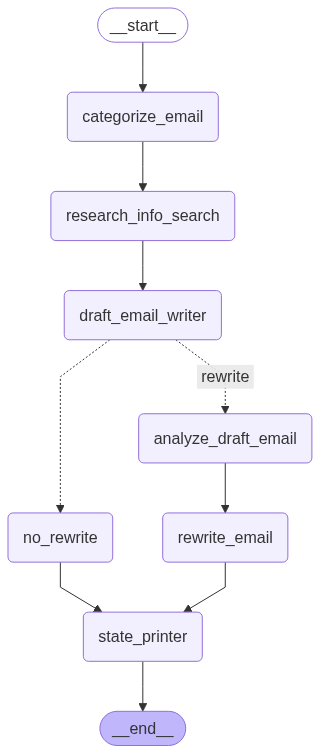

In [223]:
# Visualize your graph
from IPython.display import Image, display
png = app.get_graph().draw_mermaid_png()

display(Image(png))